# Use Logic to Handle Missing Data

## Introduction
The COVID-19 pandemic has afflicted humanity for nearly 3 years since the beginning of 2019, and we still don't seem to see the light of day。COVID is not a good object to touch.

But as a Data Scientist, COVID dataset is a good subject to touch. As it has abundant data from around the world. What's more, it is updating everyday.

Today, I would like to go back to 2019 and analyze the initial dataset of CCOVID. Credit to Kaggle for sharing the data:

https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset

Here are the data shared in the link, which includes below datasets:

* COVID19_line_list_data.csv(358.85 KB)--> report for each confirmed case
* COVID19_open_line_list.csv(2.93 MB)--> more detail about the confirmed case
* covid_19_data.csv(1.53 MB)--> confirmed data for each country
* time_series_covid_19_confirmed.csv(100.3 KB)--> confirmed data for each country,each column is timestamp
* time_series_covid_19_confirmed_US.csv(1.11 MB)--> COVID data in US
* time_series_covid_19_deaths_US.csv(1.04 MB)--> Death data in US
* time_series_covid_19_deaths.csv(76.09 KB)-->  Death data for each country
* time_series_covid_19_recovered.csv(84.62 KB)-->Recovered data

We would like to have an initial EDA for one of the datasets (COVID19_line_list_data) and demonstrate the missing data handling.

## Get Hands Dirty

As always, we shall import the modules and read data from csv.

In [18]:
import plotly.graph_objects as go
from collections import Counter
import missingno as msno
import pandas as pd
line_list_data_file = '../data/COVID19_line_list_data.csv'
line_list_data_raw_df = pd.read_csv(line_list_data_file)
line_list_data_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1085 non-null   int64  
 1   case_in_country        888 non-null    float64
 2   reporting date         1084 non-null   object 
 3   Unnamed: 3             0 non-null      float64
 4   summary                1080 non-null   object 
 5   location               1085 non-null   object 
 6   country                1085 non-null   object 
 7   gender                 902 non-null    object 
 8   age                    843 non-null    float64
 9   symptom_onset          563 non-null    object 
 10  If_onset_approximated  560 non-null    float64
 11  hosp_visit_date        507 non-null    object 
 12  exposure_start         128 non-null    object 
 13  exposure_end           341 non-null    object 
 14  visiting Wuhan         1085 non-null   int64  
 15  from

## Drop NaN Columns
Obviously, we realize that column 21-26 have 0 non-null values, it means these columns are non-informative and can be dropped safely.


In [19]:
line_list_data_raw_df.dropna(axis=1, how='all', inplace=True)
line_list_data_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1085 non-null   int64  
 1   case_in_country        888 non-null    float64
 2   reporting date         1084 non-null   object 
 3   summary                1080 non-null   object 
 4   location               1085 non-null   object 
 5   country                1085 non-null   object 
 6   gender                 902 non-null    object 
 7   age                    843 non-null    float64
 8   symptom_onset          563 non-null    object 
 9   If_onset_approximated  560 non-null    float64
 10  hosp_visit_date        507 non-null    object 
 11  exposure_start         128 non-null    object 
 12  exposure_end           341 non-null    object 
 13  visiting Wuhan         1085 non-null   int64  
 14  from Wuhan             1081 non-null   float64
 15  deat

## Missing Data Exploration

This dataset is not very large and includes missing data for certain columns, like age, country, etc. For such small scale dataset, it provides us the chance to visualize all data samples.


missingno package is used to visualize the missing data info for small dataset. e.g. nullity matrix is a data-dense display which lets you quickly visually pick out patterns in data completion. Except for matrix, you can also choose bar chart, dendrogram, etc. (https://github.com/ResidentMario/missingno)
So, we can display all samples in a matrix below.

<AxesSubplot:>

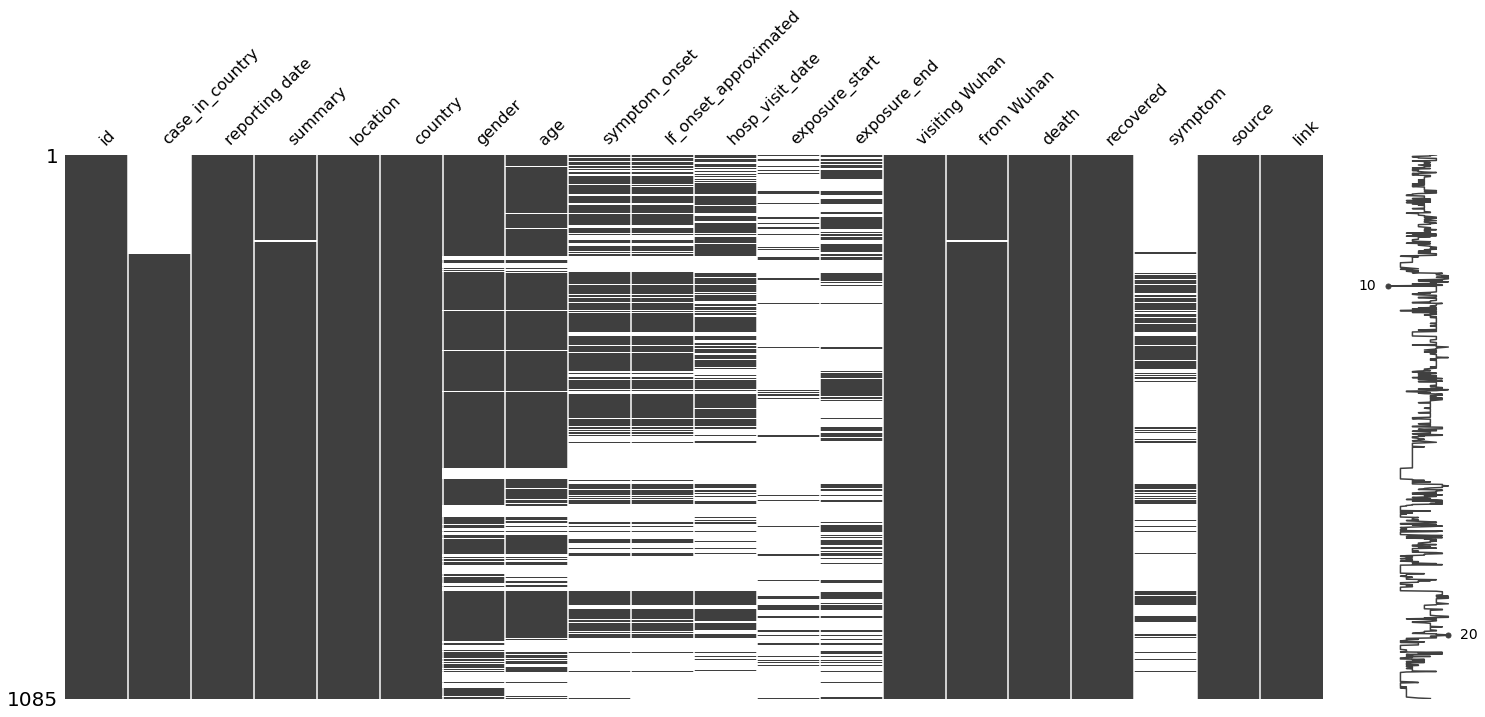

In [20]:
msno.matrix(df=line_list_data_raw_df, fontsize=16)


The results are as follows: 

- Y-axis indicated dataset size. As for our case,total dataset size is 1085. 
- The X-axis shows each feature name, because we have limited features, they all can be clearly displayed. 
- The black color indicates that feature samples are complete(not Nan). While, white gaps indicate that sepcific feature has   missing data. 
- As you can see, that ```case_in_country``` has missing samples and is concentrated at the beginning. 
- Also, a curve (sparkline) on the right side of the plot shows the number of features per row (sample). For example, there is a number 10, which means that the row has only 10 valid features, and the number 20 means that maximum feature numbers are 20.

## Handle Messy Datetime Format

One of the most important processes of data cleaning is missing data imputing. 
For this dataset, we can try plenty of ways of data filling. These filling ideas shared in the post may not be the best, but the purpose is to show the possibilities of different filling methods. 

We don't want to limit our insight filling missing filed with constants, averages, or other simple statistical indicators.

let us plot the trend firstly.


In [21]:
date_cols = [
    'reporting date',
    'symptom_onset',
    'hosp_visit_date',
    'exposure_start',
    'exposure_end']
import plotly.offline as pyo
pyo.init_notebook_mode()
fig = go.Figure()
for col in date_cols:
    fig.add_trace(go.Scatter(y=line_list_data_raw_df[col], name=col))
fig.show()
#fig.write_image("img/messy_datetime.png")


As we can see from y axis, the labels are in a mess. Because these values are recorded as string type rather than datetime. 

A good practice is to covert these datetime strings to datetime format. Since we are using Panda DataFrame to process data, it is handy to use pandas ```to_datetime```.

We would like to have closer view of these datetime string format before converting.

In [22]:
print(line_list_data_raw_df[date_cols].head(5))
print(line_list_data_raw_df[date_cols].tail(5))

# check the length of date
for col in date_cols:
    date_len = line_list_data_raw_df[col].astype(str).apply(len)
    date_len_ct = Counter(date_len)
    print(f'{col} datetime length distributes as {date_len_ct}')

# handle mix time format

  reporting date symptom_onset hosp_visit_date exposure_start exposure_end
0      1/20/2020      01/03/20        01/11/20     12/29/2019     01/04/20
1      1/20/2020     1/15/2020       1/15/2020            NaN     01/12/20
2      1/21/2020      01/04/20       1/17/2020            NaN     01/03/20
3      1/21/2020           NaN       1/19/2020            NaN          NaN
4      1/21/2020           NaN       1/14/2020            NaN          NaN
     reporting date symptom_onset hosp_visit_date exposure_start exposure_end
1080      2/25/2020           NaN             NaN            NaN          NaN
1081      2/24/2020           NaN             NaN            NaN          NaN
1082      2/26/2020           NaN             NaN            NaN    2/17/2020
1083      2/25/2020           NaN             NaN      2/19/2020    2/21/2020
1084      2/25/2020     2/17/2020             NaN      2/15/2020    2/15/2020
reporting date datetime length distributes as Counter({9: 894, 8: 190, 3: 1})
symp

We can find from above result, the datetime format is not universal. Some months as using 01, but others are using 1. since they are mixed datetime, so we have to handle these exceptions carefully.

Here is a tip, since we know there are two kinds of format.We can convert all dataset by using each format. For mismatched datetime strings, we can set them to NaT and drop them. 
Later on, we can put subsets of converted for each format back to one complete dataset again.



In [23]:
def mixed_dt_format_to_datetime(series, format_list):
    temp_series_list = []
    for format in format_list:
        temp_series = pd.to_datetime(series, format=format, errors='coerce')
        temp_series_list.append(temp_series)
    out = pd.concat([temp_series.dropna(how='any')
                     for temp_series in temp_series_list])
    return out


for col in date_cols:
    line_list_data_raw_df[col] = mixed_dt_format_to_datetime(
        line_list_data_raw_df[col], ['%m/%d/%Y', '%m/%d/%y'])
print(line_list_data_raw_df[date_cols].info())

# check the length of date
for col in date_cols:
    date_len = line_list_data_raw_df[col].astype(str).apply(len)
    date_len_ct = Counter(date_len)
    print(f'{col} datetime length distributes as {date_len_ct}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   reporting date   1084 non-null   datetime64[ns]
 1   symptom_onset    563 non-null    datetime64[ns]
 2   hosp_visit_date  506 non-null    datetime64[ns]
 3   exposure_start   128 non-null    datetime64[ns]
 4   exposure_end     341 non-null    datetime64[ns]
dtypes: datetime64[ns](5)
memory usage: 42.5 KB
None
reporting date datetime length distributes as Counter({10: 1084, 3: 1})
symptom_onset datetime length distributes as Counter({10: 563, 3: 522})
hosp_visit_date datetime length distributes as Counter({3: 579, 10: 506})
exposure_start datetime length distributes as Counter({3: 957, 10: 128})
exposure_end datetime length distributes as Counter({3: 744, 10: 341})


In [24]:
fig = go.Figure()
for col in date_cols:
    fig.add_trace(go.Scatter(y=line_list_data_raw_df[col], name=col))
fig.show()

#fig.write_image("img/clean_datetime.png")


At this moment, we can plot these trends again, and  Y-axis has become a well-organized timeline.

* When we observe the curve, and we can see that the ```report_date``` curve is at the top, which is the latest time. It is very logical and practical.
* If ```hospitalize_date``` is missing, we can directly use the ```report_date``` respectively.
* According to common sense, generally patients will go to the hospital after a period of time or immediately after they have symptoms. Therefore hospitalize_date must be later than ```symbol_onse``` time. 
* Here we can make statistics to see how long the patient will go to the hospital after having symptoms, and use this as a basis to shift back the ```symbol_onset``` time.
* Similarly, we can count the difference between the start time of the exposure history and the time of the patient's onset, so fill in the exposure_start.
* As for the missing value of ```exposure_end```, we have reason to believe that the exposure history ended when the patient was transferred to the hospital.

Here, we have sort out all ways to fill the missing date info for each datetime column.

## Fill Missing Data with Constant Value

In [25]:
# fill missing report_date
line_list_data_raw_df.loc[261, 'reporting date'] = pd.Timestamp('2020-02-11')


## Fill Missing Data with Other Column

As we can see below histogram, the gap between reporting date and hosp_visit_date close to 1. For simplify, we just use reporting date to fill hosp_visit_date.

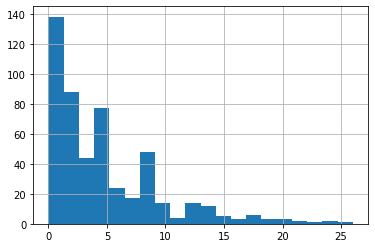

In [26]:
time_delta = line_list_data_raw_df['reporting date'] - \
    line_list_data_raw_df['hosp_visit_date']
time_delta.dt.days.hist(bins=20)
line_list_data_raw_df['hosp_visit_date'].fillna(
    line_list_data_raw_df['reporting date'], inplace=True)

## Fill Missing Data with Other Column + Bias

Similarly, we can look at the distribution of the time difference between hospital_visit and patients with symptoms. This time the highest point of the distribution is no longer around 1 day, but 3 days. 
That is to say, most people go to the hospital in 3 days after they have symptoms, and some people go to the hospital even close to 25 days. 

Therefore, we use the method of calculating the mean  value, and then reverse symptom_onset according to the hosp_visit_date.

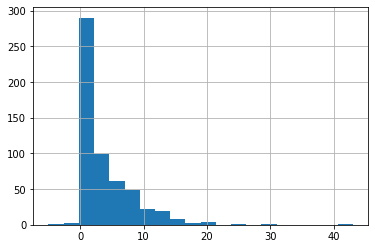

In [27]:
#fill missing symptom_onset
time_delta = line_list_data_raw_df['hosp_visit_date'] - \
    line_list_data_raw_df['symptom_onset']
time_delta.dt.days.hist(bins=20)
average_time_delta = pd.Timedelta(days=round(time_delta.dt.days.mean()))
symptom_onset_calc = line_list_data_raw_df['hosp_visit_date'] - \
    average_time_delta
line_list_data_raw_df['symptom_onset'].fillna(symptom_onset_calc, inplace=True)

After most people have a history of exposure, the probability of developing symptoms is within 4 days to 10 days , which is the so-called incubation period. In the same way, we can deduce the exposure (infection) date.

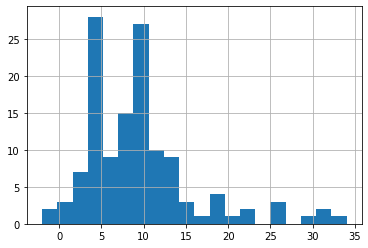

In [28]:
#fill missing exposure_start
time_delta = line_list_data_raw_df['symptom_onset'] - \
    line_list_data_raw_df['exposure_start']
time_delta.dt.days.hist(bins=20)
average_time_delta = pd.Timedelta(days=round(time_delta.dt.days.mean()))
symptom_onset_calc = line_list_data_raw_df['symptom_onset'] - \
    average_time_delta
line_list_data_raw_df['exposure_start'].fillna(symptom_onset_calc, inplace=True)

In [29]:
#fill missing exposure_end
line_list_data_raw_df['exposure_end'].fillna(line_list_data_raw_df['hosp_visit_date'], inplace=True)

As you can see the new plot, all timeline are consistent. Perfect.

In [30]:
fig = go.Figure()
for col in date_cols:
    fig.add_trace(go.Scatter(y=line_list_data_raw_df[col], name=col))
fig.show()

## Fill Other Columns

We can use same way to impute other columns.
e.g.
- for gender, you can choose use majority of gender, but here I suggest to mark unknown.
- Age can fill by mean value
- We count the word frequency and select the symbol with the highest occurrence to replace the missing value. You can see that the most common symptom is fever

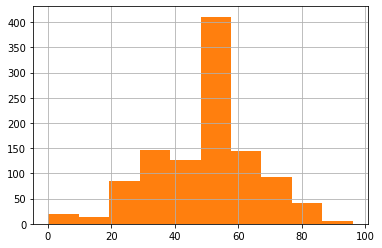

In [31]:
# we replace missing data with -1 as these are not important.
line_list_data_raw_df['case_in_country'].fillna(-1, inplace=True)

# for summary, we just replace Nan with empty string
line_list_data_raw_df['summary'].fillna('', inplace=True)

# for gender, you can choose use majority of gender, but here I suggest to mark unknown.
line_list_data_raw_df['gender'].fillna('unknown', inplace=True)

# Age can fill by mean value
line_list_data_raw_df['age'].hist(bins=10)
line_list_data_raw_df['age'].fillna(
    line_list_data_raw_df['age'].mean(), inplace=True)
line_list_data_raw_df['age'].hist(bins=10)

line_list_data_raw_df['If_onset_approximated'].fillna(1, inplace=True)

line_list_data_raw_df['from Wuhan'].fillna(1.0,inplace=True)

symptom = Counter(line_list_data_raw_df['symptom'])
# We count the word frequency and select the symbol with the highest occurrence to replace the missing value. 
# You can see that the most common symtom is fever
line_list_data_raw_df['symptom'].fillna(symptom.most_common(2)[1][0],inplace=True)

<AxesSubplot:>

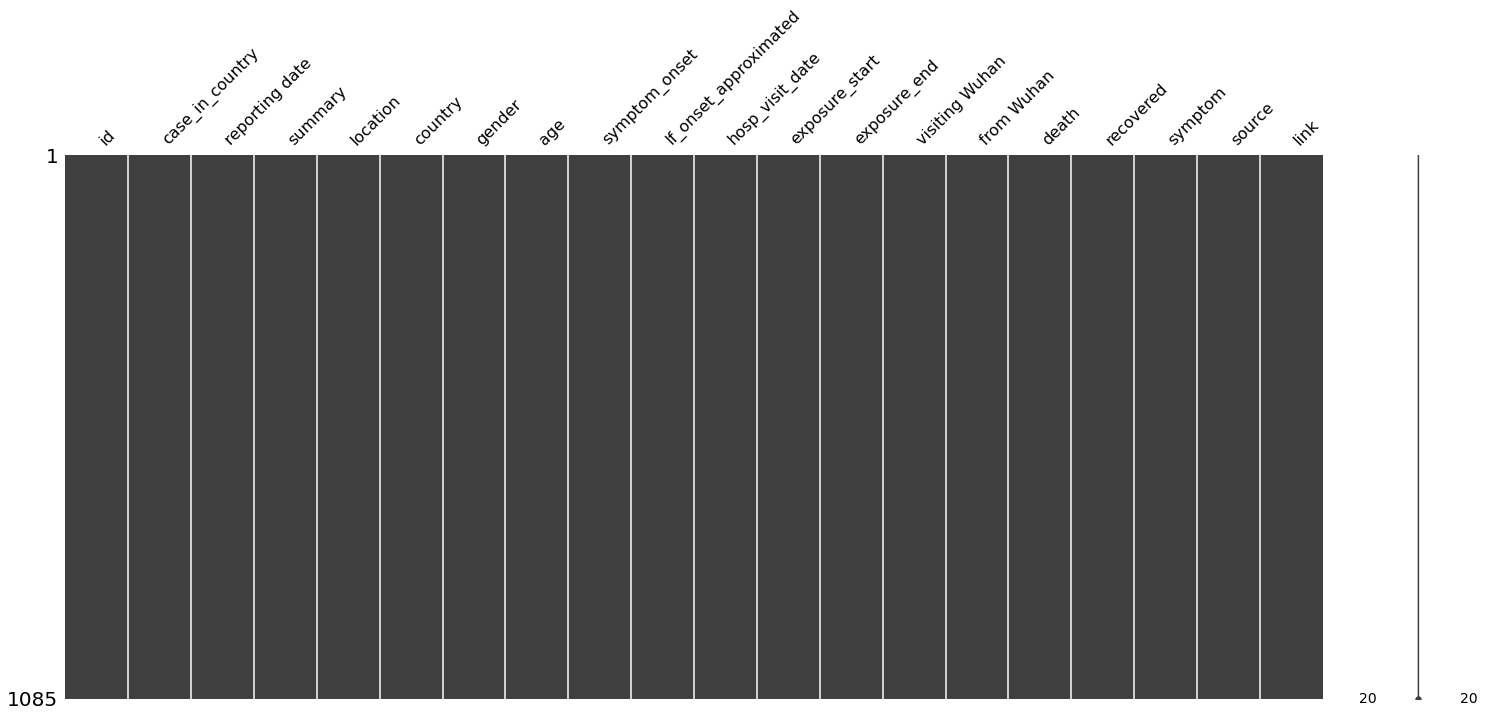

In [32]:
# missing data visualization
msno.matrix(df=line_list_data_raw_df, fontsize=16)

Check out the matrix again, bingo! Although the matrix is no longer fancy (black and white), this is the PERFECT black.

In [33]:
line_list_data_raw_df.to_csv('../data/COVID19_line_list_data_cleaned.csv')

## Summary


This post mainly introduces data cleaning, especially imputing missing data by refering logic. 

You can fill nan with a specific value, null, some statistic value, or make inferences from other columns. 

It also provides some tips, such as how to convert mixed time formats into datetime, and how to visualize missing data.

We did not perform any EDA yet on purpose, but during the process of data cleaning, we still learned a little more about the COVID.
- For example, the incubation period of patients is from 4 days to 10 days typically.

- Patients usually go to the hospital in 3 days after symptoms appear. 
- The most common symptoms are fever, and so on.